<a href="https://colab.research.google.com/github/Jih00nJung/assignment_list/blob/main/BasicLLM1_model001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import re

def clean_text(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        book_text = file.read()

    cleaned_text = re.sub(r'\n+', ' ', book_text) # 줄바꿈을 빈칸으로 변경
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text) # 여러 빈칸을 하나의 빈칸으로

    print("cleaned_" + filename, len(cleaned_text), "characters") # 글자 수 출력

    with open("cleaned_" + filename, 'w', encoding='utf-8') as file:
        file.write(cleaned_text)

filenames_list = ["Jekyll and Hyde.txt"]

for filename in filenames_list:
    clean_text(filename)

cleaned_Jekyll and Hyde.txt 157432 characters


In [16]:
pip install tiktoken

In [17]:
import tiktoken # pip install tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

text = "Mr. Utterson the lawyer was a man of a rugged countenance that was never lighted by a smile;"

tokens = tokenizer.encode(text)

print("글자수:", len(text), "토큰수", len(tokens))
print(tokens)
print(tokenizer.decode(tokens))
for t in tokens:
    print(f"{t}\t -> {tokenizer.decode([t])}")

글자수: 92 토큰수 23
[5246, 13, 7273, 23192, 262, 6853, 373, 257, 582, 286, 257, 30957, 954, 36368, 326, 373, 1239, 1657, 276, 416, 257, 8212, 26]
Mr. Utterson the lawyer was a man of a rugged countenance that was never lighted by a smile;
5246	 -> Mr
13	 -> .
7273	 ->  Ut
23192	 -> terson
262	 ->  the
6853	 ->  lawyer
373	 ->  was
257	 ->  a
582	 ->  man
286	 ->  of
257	 ->  a
30957	 ->  rugged
954	 ->  count
36368	 -> enance
326	 ->  that
373	 ->  was
1239	 ->  never
1657	 ->  light
276	 -> ed
416	 ->  by
257	 ->  a
8212	 ->  smile
26	 -> ;


In [18]:
for char in text:
    token_ids = tokenizer.encode(char)     # 한 글자씩 인코딩(토큰화)
    decoded = tokenizer.decode(token_ids)  # 한 글자씩 디코딩
    print(f"{char} -> {token_ids} -> {decoded}")

M -> [44] -> M
r -> [81] -> r
. -> [13] -> .
  -> [220] ->  
U -> [52] -> U
t -> [83] -> t
t -> [83] -> t
e -> [68] -> e
r -> [81] -> r
s -> [82] -> s
o -> [78] -> o
n -> [77] -> n
  -> [220] ->  
t -> [83] -> t
h -> [71] -> h
e -> [68] -> e
  -> [220] ->  
l -> [75] -> l
a -> [64] -> a
w -> [86] -> w
y -> [88] -> y
e -> [68] -> e
r -> [81] -> r
  -> [220] ->  
w -> [86] -> w
a -> [64] -> a
s -> [82] -> s
  -> [220] ->  
a -> [64] -> a
  -> [220] ->  
m -> [76] -> m
a -> [64] -> a
n -> [77] -> n
  -> [220] ->  
o -> [78] -> o
f -> [69] -> f
  -> [220] ->  
a -> [64] -> a
  -> [220] ->  
r -> [81] -> r
u -> [84] -> u
g -> [70] -> g
g -> [70] -> g
e -> [68] -> e
d -> [67] -> d
  -> [220] ->  
c -> [66] -> c
o -> [78] -> o
u -> [84] -> u
n -> [77] -> n
t -> [83] -> t
e -> [68] -> e
n -> [77] -> n
a -> [64] -> a
n -> [77] -> n
c -> [66] -> c
e -> [68] -> e
  -> [220] ->  
t -> [83] -> t
h -> [71] -> h
a -> [64] -> a
t -> [83] -> t
  -> [220] ->  
w -> [86] -> w
a -> [64] -> a
s -> [82] -> 

In [19]:
pip install torch

In [20]:
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, txt, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # token_ids = tokenizer.encode("<|endoftext|>" + txt, allowed_special={"<|endoftext|>"})
        token_ids = tokenizer.encode(txt)

        print("# of tokens in txt:", len(token_ids))

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

# with open("cleaned_한글문서.txt", 'r', encoding='utf-8-sig') as file: # 선택: -sig를 붙여서 BOM 제거
with open("cleaned_Jekyll and Hyde.txt", 'r', encoding='utf-8-sig') as file: # 선택: -sig를 붙여서 BOM 제거
    txt = file.read()

dataset = MyDataset(txt, max_length = 32, stride = 4)

train_loader = DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True)

# 주의: 여기서는 코드를 단순화하기 위해 test, valid는 생략하고 train_loader만 만들었습니다.
#      관련된 ML 이론이 궁금하신 분들은 train vs test vs validation 등으로 검색해보세요.

# of tokens in txt: 38096


In [21]:
dataiter = iter(train_loader)

x, y = next(dataiter)

print(tokenizer.decode(x[0].tolist()))
print(tokenizer.decode(y[0].tolist()))


 time scarce, at night under the face of the fogged city moon, by all lights and at all hours of solitude or concourse, the lawyer was to
 scarce, at night under the face of the fogged city moon, by all lights and at all hours of solitude or concourse, the lawyer was to be


In [22]:
# 모델을 정의할 때 사용하는 상수들

VOCAB_SIZE = tokenizer.n_vocab # 50257 Tiktoken
#VOCAB_SIZE = len(tokenizer) # AutoTokenizer
CONTEXT_LENGTH = 128  # Shortened context length (orig: 1024)
EMB_DIM = 768  # Embedding dimension
NUM_HEADS = 12  # Number of attention heads
NUM_LAYERS = 12  # Number of layers
DROP_RATE = 0.1  # Dropout rate
QKV_BIAS = False  # Query-key-value bias

In [23]:
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()

        assert d_out % NUM_HEADS == 0, "d_out must be divisible by n_heads"

        self.d_out = d_out
        self.head_dim = d_out // NUM_HEADS

        self.W_query = nn.Linear(d_in, d_out, bias=QKV_BIAS)
        self.W_key = nn.Linear(d_in, d_out, bias=QKV_BIAS)
        self.W_value = nn.Linear(d_in, d_out, bias=QKV_BIAS)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(DROP_RATE)
        self.register_buffer('mask', torch.triu(torch.ones(CONTEXT_LENGTH, CONTEXT_LENGTH), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)  # (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, NUM_HEADS, self.head_dim)
        values = values.view(b, num_tokens, NUM_HEADS, self.head_dim)
        queries = queries.view(b, num_tokens, NUM_HEADS, self.head_dim)

        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3)

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2)

        context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)

        return context_vec

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

class FeedForward(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(EMB_DIM, 4 * EMB_DIM),
            GELU(),
            nn.Linear(4 * EMB_DIM, EMB_DIM),
        )

    def forward(self, x):
        return self.layers(x)

class TransformerBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=EMB_DIM,
            d_out=EMB_DIM)

        self.ff = FeedForward()
        self.norm1 = LayerNorm(EMB_DIM)
        self.norm2 = LayerNorm(EMB_DIM)
        self.drop_shortcut = nn.Dropout(DROP_RATE)

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x


class GPTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.tok_emb = nn.Embedding(VOCAB_SIZE, EMB_DIM)
        self.pos_emb = nn.Embedding(CONTEXT_LENGTH, EMB_DIM)
        self.drop_emb = nn.Dropout(DROP_RATE)

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock() for _ in range(NUM_LAYERS)])

        self.final_norm = LayerNorm(EMB_DIM)
        self.out_head = nn.Linear(EMB_DIM, VOCAB_SIZE, bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [24]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print(device)

torch.manual_seed(123)
model = GPTModel()
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

cuda


In [25]:
tokens_seen, global_step = 0, -1

losses = []

for epoch in range(10):
    model.train()  # Set model to training mode

    epoch_loss = 0
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad() # Reset loss gradients from previous batch iteration
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)

        logits = model(input_batch)
        loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
        epoch_loss += loss.item()
        loss.backward() # Calculate loss gradients
        optimizer.step() # Update model weights using loss gradients
        tokens_seen += input_batch.numel()
        global_step += 1

        if global_step % 1000 == 0:
            print(f"Tokens seen: {tokens_seen}")
        # Optional evaluation step

    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch: {epoch + 1}, Loss: {avg_loss}")
    torch.save(model.state_dict(), "model_" + str(epoch + 1).zfill(3) + ".pth")

# 주의: 여기서는 편의상 모든 데이터를 train에 사용하였습니다.
#      ML에서는 일부 데이터를 validation에 사용하는 것이 일반적입니다.

Tokens seen: 4096
Epoch: 1, Loss: 5.746674627871127
Epoch: 2, Loss: 3.61037726015658
Epoch: 3, Loss: 1.905399478770591
Epoch: 4, Loss: 0.6795147540601524
Epoch: 5, Loss: 0.32458327227347605
Epoch: 6, Loss: 0.23760075081844587
Epoch: 7, Loss: 0.20704059886771278
Epoch: 8, Loss: 0.18959161941264127
Epoch: 9, Loss: 0.1784535428962192
Epoch: 10, Loss: 0.1722899131678246


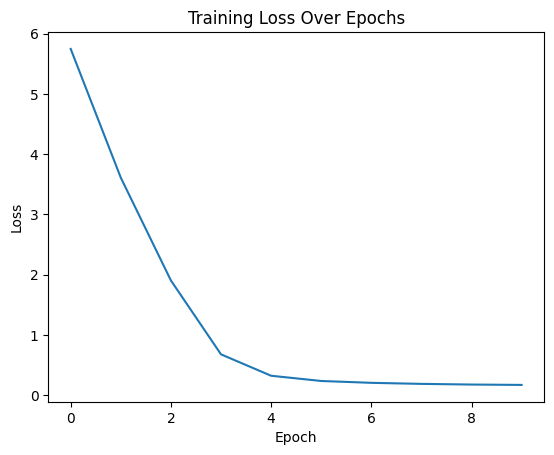

In [26]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

# 보충: validation loss를 같이 그려서 비교하는 사례 https://www.geeksforgeeks.org/training-and-validation-loss-in-deep-learning/

In [38]:
# 파일로 저장했던 네트워크의 가중치들 읽어들이기
model.load_state_dict(torch.load("model_001.pth", map_location=device, weights_only=True))
model.eval() # dropout을 사용하지 않음

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(128, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [31]:
idx = tokenizer.encode("Dobby is") # 토큰 id의 list
idx = torch.tensor(idx).unsqueeze(0).to(device)

with torch.no_grad():
    logits = model(idx)

logits = logits[:, -1, :]

# 가장 확률이 높은 단어 10개 출력
top_logits, top_indices = torch.topk(logits, 10)
for p, i in zip(top_logits.squeeze(0).tolist(), top_indices.squeeze(0).tolist()):
    print(f"{p:.2f}\t {i}\t {tokenizer.decode([i])}")

# 가장 확률이 높은 단어 출력
idx_next = torch.argmax(logits, dim=-1, keepdim=True)
flat = idx_next.squeeze(0) # 배치 차원 제거 torch.Size([1])
out = tokenizer.decode(flat.tolist()) # 텐서를 리스트로 바꿔서 디코드
print(out)

9.83	 635	  also
9.50	 257	  a
9.36	 10944	  derived
8.34	 6507	  sad
8.11	 991	  still
7.79	 5421	  bound
7.03	 5884	  connected
6.90	 530	  one
6.77	 8631	  plain
6.54	 880	  well
 also


In [32]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:
            break

        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [37]:
start_context = input("Start context: ")

# idx = tokenizer.encode(start_context, allowed_special={'<|endoftext|>'})
idx = tokenizer.encode(start_context)
idx = torch.tensor(idx).unsqueeze(0)

context_size = model.pos_emb.weight.shape[0]

for i in range(10):

    token_ids = generate(
        model=model,
        idx=idx.to(device),
        max_new_tokens=50,
        context_size= context_size,
        top_k=50,
        temperature=0.5
    )

    flat = token_ids.squeeze(0) # remove batch dimension
    out = tokenizer.decode(flat.tolist()).replace("\n", " ")

    print(i, ":", out)

Start context: hyde
0 : hyde. The lawyer put it in his pocket. “I would say nothing of this paper. If your master has fled or is dead, we may at least save his fears incline to make any degree of your sake, we may at least save
1 : hyde. The lawyer put it in his pocket. “I would say nothing of this paper. If your master has fled or is dead, we may at least save his head like a question, we may be used to be more than myself when you
2 : hyde, like a district of some city in a nightmare. The thoughts of his mind, besides, were of the gloomiest dye; and when he glanced at the change a somewhat theatrical to hope me in one of his companion seemed to another begins, he
3 : hyde of self-defence. Twelve o’clock had scarce rung out over London, ere the knocker sounded very gently on the door. I went so disagreeably preoccupied his shoulder as he went so long ago. I went so
4 : hyde of wonder at my vicarious depravity. This familiar that I called out of my own soul, and sent forth alone to do 